In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import RobustScaler
pd.set_option('display.max_columns', None)  # Unlimited columns
from fastai.tabular import *

In [3]:
pwd

'/home/ec2-user/SageMaker/water-pumps-2/notebooks'

In [4]:
# data_path = '/app/data/raw/'
data_path = '/home/ec2-user/SageMaker/water-pumps-2/data/raw/'

In [5]:
X_test = pd.read_csv(data_path + 'test_features.csv')
X_train = pd.read_csv(data_path + 'train_features.csv')
y_train = pd.read_csv(data_path + 'train_labels.csv')

In [6]:
def wrangle(X):
    """
    All-inclusive data cleanup.
    """
 
    # Make a clean copy, to ensure we're not changing the original DF
    X = X.copy()
    
    # Looking at all the features with missing values, it looks like those
    # features are all categorical variables where 'unknown' would be a
    # category we can work with.  I'll replace the NANs accordingly.
    X = X.fillna('unknown')
    
    # Regression on dates won't work.  Instead, I'll turn the 
    # date_recorded column into the number of years since 2000
    # (the earliest date in the training date is from ~2002, and the
    # latest from 2013.)
    dates = pd.to_datetime(X.date_recorded)
    year2000 = pd.to_datetime('2000-01-01')
    years = [i.days/365 for i in (dates - year2000)]
    X.date_recorded = years
    
    # region_code and district_code are int64, but they should really be
    # treated as categories (and there's only 20-30 classes in each).
    # I'll cast them as strings instead.
    X.region_code = X.region_code.astype('str')
    X.district_code = X.district_code.astype('str')
      
    # To prevent data conversion warnings, I'll turn all the numerical
    # features (except id) into float64.
    
    # Also, some columns contained bool values and NANs.  
    # (e.g., public_meeting, permit)
    # I replaced the NANs with strings, which created a problem for later
    # operations that don't like heterogeneous datatypes within a single
    # column. I'll prevent this problem by casting those two features as str.
    
    type_dict = {'amount_tsh':'float64',
                 'date_recorded':'float64',
                 'gps_height':'float64',
                 'longitude':'float64',
                 'latitude':'float64',
                 'num_private':'float64',
                 'population':'float64',
                 'construction_year':'float64',
                 'public_meeting':'str',
                 'permit':'str'}
    
    X = X.astype(dtype = type_dict)
    
    # Fixing the numerical columns.
    # ---------------------------------------------------------------    
    
    # Numerical columns have several kinds of garbage values that 
    # Must be replaced with nulls.
    numericals = ['amount_tsh',
                    'date_recorded',
                    'gps_height',
                    'longitude',
                    'latitude',
                    'num_private',
                    'population',
                    'construction_year']

    null_values = {'amount_tsh':0,
                     'date_recorded':0,
                     'gps_height':0,
                     'longitude':0,
                     'latitude':-2.000000e-08,
                     'num_private':0,
                     'population':0,
                     'construction_year':0}

    # I replace all garbage values with NANs.
    for feature, null in null_values.items():
        X[feature] = X[feature].replace(null, np.nan)
    
    # construction_year occasionally claims years far in the future, and 
    # could presumably also contain years way in the past.  I'll turn anything
    # not between 1960 and 2019 into a NAN.
    X['construction_year'] = [i if 1960 < i < 2019 else np.nan for i in X['construction_year']]

    
    # Whenever available, a good replacement value for a NAN is the 
    # mean or median value for the geographic region around it.

    # Replaces the NANs in a ward with the mean of the other rows in that 
    # same ward. If all the rows in a ward are NANs, though, they remain.
    for feature in numericals:
        replacements = X.groupby('ward')[feature].transform('mean')
        X[feature] = X[feature].fillna(replacements)

    # Replaces the NANs in a region with the mean of the other rows in that 
    # same region (which are much larger than wards)
    for feature in numericals:
        replacements = X.groupby('region')[feature].transform('mean')
        X[feature] = X[feature].fillna(replacements)
    
    # A few rows are not helped by averaging over the ward or the region.
    # Those can stay as they are, with NANs.
    
    # Fixing the categorical columns.
    # ---------------------------------------------------------------    
    
    # Create list of categorical features
    categoricals = X.select_dtypes(exclude='number').columns.tolist()

    # Make all strings lowercase, to collapse together some of the categories
    X[categoricals] = X[categoricals].applymap(lambda x: x.lower())

    # Replace common NAN values
    nan_list = ['not known','unknown','none','-','##','not kno','unknown installer']
    X = X.replace(nan_list, np.nan)

    # Any feature values with fewer than 50 rows gets turned into a NAN
    for feature in X[categoricals]:
        # Determine which feature values to keep
        to_keep = X[feature].value_counts()[X[feature].value_counts() > 50].index.tolist()
        # Turn those into NANs (using a copy, to prevent warnings)
        feature_copy = X[feature].copy()
        feature_copy[~feature_copy.isin(to_keep)] = np.nan
        X[feature] = feature_copy
    
    
    garbage = ['id','extraction_type_group','extraction_type_class',
               'region_code','waterpoint_type_group','source_type',
              'payment_type','quality_group','quantity_group',
              'recorded_by']
    
    X = X.drop(columns=garbage)
    
    X['age'] = X['date_recorded'] - X['construction_year']
    
    return X

In [7]:
X_train = wrangle(X_train)
X_test = wrangle(X_test)

# Default embeddings

In [53]:
train = X_train.copy()
train['y'] = y_train['status_group']

In [54]:
dep_var = 'y'
cat_names = X_train.select_dtypes(exclude='number').columns.tolist()
cont_names = X_train.select_dtypes('number').columns.tolist()
procs = [FillMissing, Categorify, Normalize] 

test = TabularList.from_df(X_test, 
                           cat_names=cat_names, 
                           cont_names=cont_names)

data = (TabularList.from_df(train, 
                            cat_names=cat_names, 
                            cont_names=cont_names, 
                            procs=procs)
                           .split_by_idx(list(range(50000,59400)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [66]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(143, 26)
    (1): Embedding(126, 24)
    (2): Embedding(36, 12)
    (3): Embedding(10, 6)
    (4): Embedding(61, 16)
    (5): Embedding(22, 9)
    (6): Embedding(18, 8)
    (7): Embedding(124, 24)
    (8): Embedding(309, 40)
    (9): Embedding(3, 3)
    (10): Embedding(12, 6)
    (11): Embedding(87, 20)
    (12): Embedding(3, 3)
    (13): Embedding(16, 8)
    (14): Embedding(12, 6)
    (15): Embedding(5, 4)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(5, 4)
    (19): Embedding(10, 6)
    (20): Embedding(3, 3)
    (21): Embedding(7, 5)
    (22): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=255, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


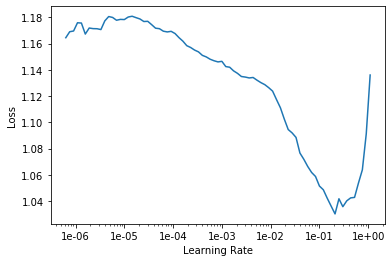

In [55]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(3, max_lr=1e-2) # Steepest point on the downward slope

epoch,train_loss,valid_loss,accuracy,time
0,0.594301,0.581946,0.757553,00:22
1,0.567364,0.542184,0.781808,00:26
2,0.497569,0.526949,0.787447,00:24


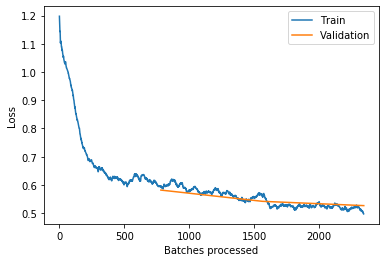

In [57]:
learn.recorder.plot_losses()
learn.save('stage1-3y')

# xgboost

In [11]:
def get_proc_df(tll):
    """Get processed xs and ys from a tabular `LabelList` with a single value for label such as FloatList.
       For example from `TabularDataBunch.train_ds`.
       :param tll: A tabular `LabelList`. 
       :returns: A tuple of `(x,y)` where `x` is a pandas `DataFrame` and `y` is a numpy array.
    """
    x_vals = np.concatenate([tll.x.codes, tll.x.conts], axis=1)
    x_cols = tll.x.cat_names + tll.x.cont_names
    x_df = pd.DataFrame(data=x_vals, columns=x_cols)[
            [c for c in tll.inner_df.columns if c in x_cols] ] # Retain order
    # Reconstruct ys to apply log if specified
    y_vals = np.array([i.obj for i in tll.y])
    return x_df, y_vals

In [12]:
X_train_processed, y_train_processed = get_proc_df(data.train_ds)
X_valid_processed, y_valid_processed = get_proc_df(data.valid_ds)

In [145]:
from xgboost import XGBClassifier

modelxgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', 
                         nrounds = 'min.error.idx', num_class = 3, 
                         maximize = False, eval_metric = 'merror', eta = .1,
                         max_depth = 14, colsample_bytree = .4, n_jobs=-1)

In [146]:
%%time
modelxgb.fit(X_train_processed, y_train_processed)

CPU times: user 1min 3s, sys: 5.37 s, total: 1min 8s
Wall time: 44.1 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.1,
              eval_metric='merror', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=14, maximize=False,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nrounds='min.error.idx', nthread=None, num_class=3,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [151]:
from sklearn.metrics import accuracy_score
y_pred = modelxgb.predict(X_valid_processed)

In [152]:
score = accuracy_score(y_valid_processed, y_pred)

In [153]:
score

0.8181914893617022

In [156]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(modelxgb, X_train_processed, y_train_processed, scoring='accuracy', cv=5)

In [158]:
cv_score.mean()

0.8123198792403988

# Custom embeddings

In [10]:
dep_var = 'y'
cat_names = X_train.select_dtypes(exclude='number').columns.tolist()
cont_names = X_train.select_dtypes('number').columns.tolist()
procs = [FillMissing, Categorify, Normalize] 

test = TabularList.from_df(X_test, 
                           cat_names=cat_names, 
                           cont_names=cont_names)

data = (TabularList.from_df(train, 
                            cat_names=cat_names, 
                            cont_names=cont_names, 
                            procs=procs)
                           .split_by_idx(list(range(50000,59400)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [13]:
categories = X_train_processed[cat_names].nunique().keys().to_list()
cardinalities = X_train_processed[cat_names].nunique().values
emb_szs = {cat: min(50, card//2) for cat, card in zip(categories, cardinalities)}
emb_szs

{'funder': 50,
 'installer': 50,
 'wpt_name': 18,
 'basin': 4,
 'subvillage': 30,
 'region': 10,
 'district_code': 9,
 'lga': 50,
 'ward': 50,
 'public_meeting': 1,
 'scheme_management': 6,
 'scheme_name': 43,
 'permit': 1,
 'extraction_type': 8,
 'management': 6,
 'management_group': 2,
 'payment': 3,
 'water_quality': 3,
 'quantity': 2,
 'source': 5,
 'source_class': 1,
 'waterpoint_type': 3,
 'num_private_na': 1}

In [14]:
train = X_train.copy()
train['y'] = y_train['status_group']

In [47]:
learn = tabular_learner(data, emb_szs=emb_szs, layers=[1000,500], 
                        ps=[0.001,0.01], metrics=accuracy, emb_drop=0.04)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(143, 50)
    (1): Embedding(126, 50)
    (2): Embedding(36, 18)
    (3): Embedding(10, 4)
    (4): Embedding(61, 30)
    (5): Embedding(22, 10)
    (6): Embedding(18, 9)
    (7): Embedding(124, 50)
    (8): Embedding(309, 50)
    (9): Embedding(3, 1)
    (10): Embedding(12, 6)
    (11): Embedding(87, 43)
    (12): Embedding(3, 1)
    (13): Embedding(16, 8)
    (14): Embedding(12, 6)
    (15): Embedding(5, 2)
    (16): Embedding(7, 3)
    (17): Embedding(7, 3)
    (18): Embedding(5, 2)
    (19): Embedding(10, 5)
    (20): Embedding(3, 1)
    (21): Embedding(7, 3)
    (22): Embedding(3, 1)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=365, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.

In [48]:
learn.save('1000-500-fresh')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


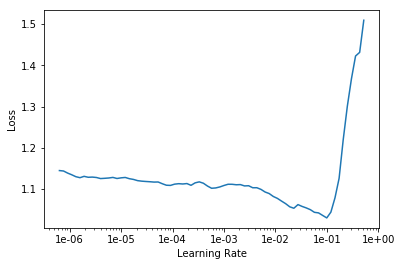

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10, max_lr=1e-2) # Steepest point on the downward slope

epoch,train_loss,valid_loss,accuracy,time
0,0.603100,0.598857,0.754468,00:10
1,0.596605,0.583666,0.757340,00:11
2,0.574523,0.560102,0.773936,00:11
3,0.559919,0.546155,0.778192,00:11
4,0.536715,0.538945,0.782979,00:10
5,0.510305,0.576241,0.780745,00:11
6,0.488233,0.560490,0.790426,00:11
7,0.469493,0.540226,0.795000,00:11
8,0.445577,0.537415,0.796915,00:11
9,0.423417,0.525479,0.796702,00:11


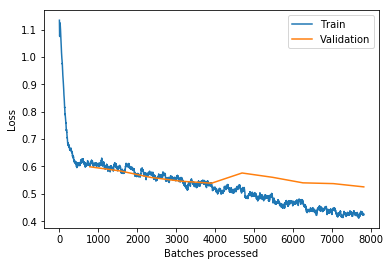

In [30]:
learn.recorder.plot_losses()

In [49]:
learn.load('1000-500-fresh')
learn.fit_one_cycle(5, max_lr=1e-2) # Steepest point on the downward slope
learn.save('1000-500-5cycles')

epoch,train_loss,valid_loss,accuracy,time
0,0.629175,0.614797,0.739787,00:11
1,0.582500,0.555476,0.771489,00:11
2,0.545684,0.537219,0.779468,00:11
3,0.517010,0.519902,0.789894,00:11
4,0.480589,0.518854,0.788191,00:11


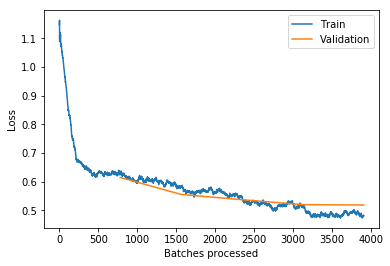

In [50]:
learn.recorder.plot_losses()

In [52]:
learn.fit_one_cycle(3, max_lr=1e-2) # Steepest point on the downward slope

epoch,train_loss,valid_loss,accuracy,time
0,0.535637,0.538864,0.784362,00:11
1,0.519382,0.524623,0.787553,00:11
2,0.483919,0.513784,0.792447,00:11


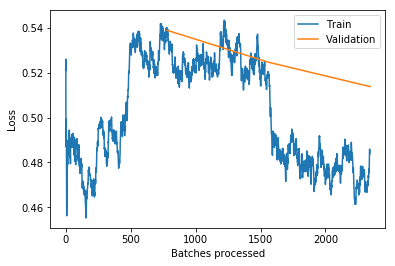

In [53]:
learn.recorder.plot_losses()

In [ ]:
learn.save('1000-500-8cycles')

# Export

In [ ]:
# Export answers
test_preds=learn.get_preds(DatasetType.Test)
pred_numerical = [np.argmax(x).item() for x in test_preds[0]]
y_test = [learn.data.classes[x] for x in pred_numerical]

submission = pd.read_csv(data_path + 'sample_submission.csv')
submission['status_group'] = y_test

# submission.to_csv('answers2.csv', index=False)